In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
print pd.__version__

0.24.2


In [3]:
def is_msk(zone_i):
    if zone_i <= 10:
        return 1
    else:
        return 0

In [4]:
def trips_adjusted(zone_i, n_livers_i_to_j):
    if (is_msk(zone_i) == 1):
        return float(n_livers_i_to_j) * 1.62 # Because Moskow population is 1.62 times larger, than Region's
    else:
        return float(n_livers_i_to_j)

In [5]:
data_raw = pd.read_csv("trips.csv", names=['zone_i', 'zone_j', 'n_livers_i_to_j', 'avg_travel_time', 'avg_distance_to_work'])
data = data_raw[data_raw.n_livers_i_to_j > 0]

data["is_msk"] = data.zone_i.apply(is_msk)
data["n_livers_i_to_j_adj"] = [trips_adjusted(data.zone_i[k], data.n_livers_i_to_j[k]) for k in range(data.shape[0])]

print(data.shape)
data.head(20)

(210, 7)


,zone_i,zone_j,n_livers_i_to_j,avg_travel_time,avg_distance_to_work,is_msk,n_livers_i_to_j_adj
0,1,1,40,26,2.2,1,64.80
1,1,2,4,49,8.1,1,6.48
2,1,3,3,35,6.8,1,4.86
3,1,4,2,75,9.3,1,3.24
4,1,5,2,30,8.0,1,3.24
5,1,6,4,52,9.9,1,6.48
6,1,7,6,48,13.0,1,9.72
7,1,8,3,48,12.3,1,4.86
8,1,11,1,30,16.9,1,1.62
9,1,13,2,50,21.9,1,3.24


*TODO* применить алгоритм!

In [6]:
def calc_O(df):
    return np.array([df.n_livers_i_to_j[df.zone_i==i].sum() for i in df.zone_i])

def calc_D(df):
    return np.array([df.n_livers_i_to_j[df.zone_j==j].sum() for j in df.zone_j])


# Рассчитывает F_ij
# Причем в результате получается не матрица, а массив
# (который можно приписать к датафрейму, он такой же длины)

def calc_F(df, O, D, A, B):
    return [float(df.n_livers_i_to_j[k]) / (A[df.zone_i[k] - 1] * B[df.zone_j[k] - 1] * O[k] * D[k])
            for k in range(df.shape[0])]


In [7]:
def calc_O_adj(df):
    return np.array([df.n_livers_i_to_j_adj[df.zone_i==i].sum() for i in df.zone_i])

def calc_D_adj(df):
    return np.array([df.n_livers_i_to_j_adj[df.zone_j==j].sum() for j in df.zone_j])


# Делает то же самое, что и предыдущая ячейка, но только для "n_livers_i_to_j_adj" вместо "n_livers_i_to_j"

def calc_F_adj(df, O, D, A, B):
    return [float(df.n_livers_i_to_j_adj[k]) / (A[df.zone_i[k] - 1] * B[df.zone_j[k] - 1] * O[k] * D[k])
            for k in range(df.shape[0])]


In [8]:
# ?plt.scatter

In [9]:
def plot_log_F(df, F, msk_red=False):
    F_log = -np.log(F)
    colours = {0:"#1c74b2", 1:"#b0273b"}
    if msk_red:
        plt.scatter(x=df.avg_travel_time, y=F_log, alpha=0.64,
                    c=df.is_msk.apply(lambda x: colours[x]))
        
    else:
        plt.scatter(x=df.avg_travel_time, y=F_log, alpha=0.64, c=colours[0])
        
    plt.show()

In [10]:
O = calc_O(data)
D = calc_D(data)

In [11]:
# ?np.array

In [12]:
A0 = np.ones(data.zone_i.unique().shape)
B0 = np.ones(data.zone_j.unique().shape)

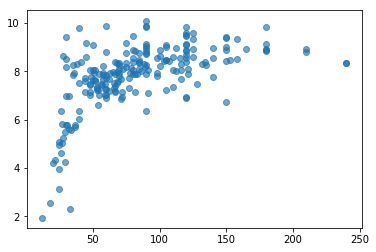

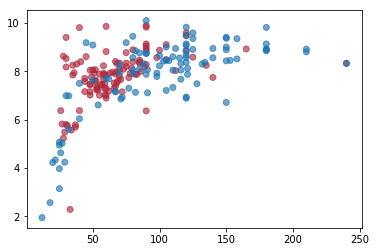

In [13]:
F = calc_F(data, O, D, A0, B0)
plot_log_F(data, F)
plot_log_F(data, F, msk_red=True)

In [14]:
O_adj = calc_O_adj(data)
D_adj = calc_D_adj(data)

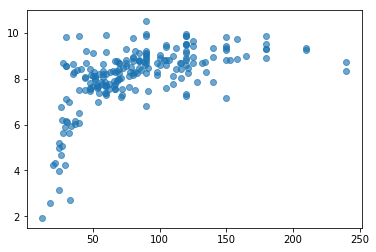

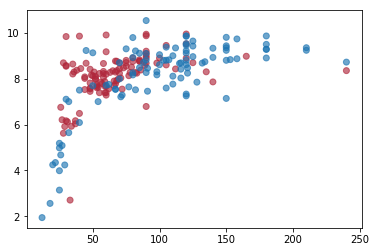

In [15]:
F_adj = calc_F_adj(data, O_adj, D_adj, A0, B0)
plot_log_F(data, F_adj)
plot_log_F(data, F_adj, msk_red=True)

## Минимизация разброса
### 1 вариант
1. Расширить пространство признаков - добавить t ** 2, t ** 3.
2. Обучить на нем лин. регрессию, померять качество
3. Запустить scipy.optimize.minimize( - результат 1. и 2.)

### 2 вариант
1. Расширить пространство признаков - помимо t ** 2 и t ** 3 ввести бинарные признаки принадлежности каждой зоне
2. Обучить лин. регрессию.
3. Проинтерпретировать коэффициенты при бинарных признаках, как нечто, связанное с A_i и B_j
